# Celltype Classification with Transcriptformer

This notebooks showcase how the Transcriptformer embeddings can be used to train a classifier for celltype classification.

In [1]:
%load_ext autoreload
%autoreload 2

import json
import logging
import os

import hydra
from omegaconf import DictConfig, OmegaConf


from transcriptformer.model.inference import run_inference
from transcriptformer.datasets import tabula_sapiens
import yaml

In [2]:
# !python ./../download_artifacts.py tf-sapiens

In [2]:
adata = tabula_sapiens(tissue="bone_marrow", version="v2")
cfg = OmegaConf.load("./../conf/inference_config.yaml")
logging.debug(OmegaConf.to_yaml(cfg))

cfg.model.checkpoint_path = "./checkpoints/tf_sapiens"

config_path = os.path.join(cfg.model.checkpoint_path, "config.json")
with open(config_path) as f:
    config_dict = json.load(f)
mlflow_cfg = OmegaConf.create(config_dict)

# Merge the MLflow config with the main config
cfg = OmegaConf.merge(mlflow_cfg, cfg)

# Set the checkpoint paths based on the unified checkpoint_path
cfg.model.inference_config.load_checkpoint = os.path.join(cfg.model.checkpoint_path, "model_weights.pt")
cfg.model.data_config.aux_vocab_path = os.path.join(cfg.model.checkpoint_path, "vocabs")
cfg.model.data_config.esm2_mappings_path = os.path.join(cfg.model.checkpoint_path, "vocabs")


/work/venv/tf311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 988M/988M [00:03<00:00, 286MB/s]  


In [3]:
adata.var["ensembl_id"] = adata.var_names.str.split('.').str[0]
adata.X = adata.layers["decontXcounts"]

In [4]:
# Set logging level to ERROR to reduce verbosity
logging.getLogger().setLevel(logging.ERROR)

adata_output = run_inference(cfg, data_files=[adata])

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/work/venv/tf311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1006/1006 [01:00<00:00, 16.57it/s]


/work/venv/tf311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    ("lr", LogisticRegression()),
                ]
            )

In [7]:
embeddings, labels = adata_output.obsm["embeddings"], adata_output.obs["cell_type"]


In [8]:
adata_map = tabula_sapiens(tissue="bone_marrow", version="v1")
adata_map.var["ensembl_id"] = adata_map.var_names.str.split('.').str[0]
adata_map.X = adata_map.layers["decontXcounts"]

In [ ]:
adata_map_output = run_inference(cfg, data_files=[adata_map])

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/work/venv/tf311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0:  92%|█████████▏| 2196/2384 [02:05<00:10, 17.47it/s]

In [41]:
embeddings_map = adata_map_output.obsm["embeddings"]
pipeline.fit(embeddings, labels)
classes = pipeline.predict(embeddings_map)


/work/venv/tf311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
labels = pd.Categorical(classes)


In [47]:

adata_map.obs['predicted_cell_type'] = labels

In [53]:
import scanpy as sc
adata_map.obsm["transcriptformer_embedding"] = embeddings_map
sc.pp.neighbors(adata_map, use_rep="transcriptformer_embedding")
sc.tl.umap(adata_map)

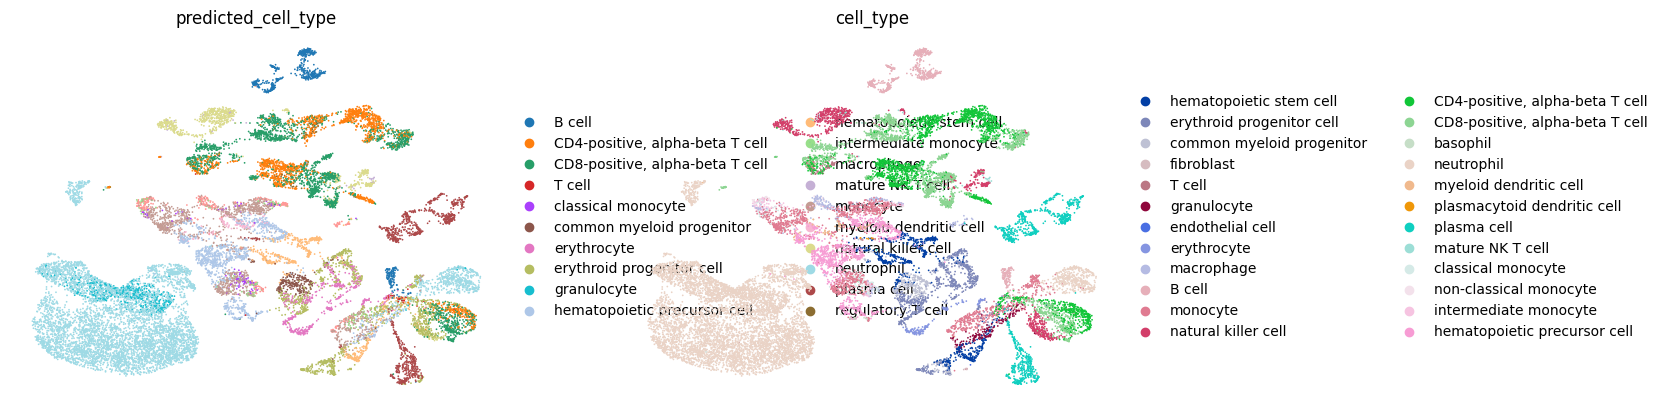

In [54]:
sc.pl.umap(adata_map, color=['predicted_cell_type', "cell_type"], ncols=2, frameon=False)